# Mercado Livre API - Visitas às páginas dos produtos
Esse notebook apresenta visitas a itens resultantes de uma query definida pelo usuário. É possível ajustar o número de itens a serem plotados no gráfico (*ITEMS_TO_PLOT*), bem como o número de dias atrás que se deseja iniciar a consulta (*DAYS_AGO*).

O código é composto por 3 partes:

### Busca de itens a partir de uma query definida pelo usuário

- Get dos resultados da busca
- Ordenamento dos itens por mais vendidos e remoção de itens duplicados
- Corte de itens pelo limite *ITEMS_TO_PLOT*

### Request por visitas dos itens filtrados e ordenados

- Get das visitas dos itens desde *DAYS_AGO* dias atrás 
- Organização dos resultados em um único **df** indexado por data
- Headers das colunas editados para serem as ids dos itens

### Visualização dos dados de 3 formas
- Visitas por dia (básico)
- Média móvel de visitas (janela da média definida no código, ainda hardcoded)
- Soma acumulada de visitas

Ao final são listados os títulos dos itens e respectivas URLs para visualização da página.

## Imports e configurações gerais

In [42]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import requests
import pandas as pd

from pandas import Series, DataFrame

from pylab import rcParams
rcParams['figure.figsize'] = 20, 10 # increases figure size
matplotlib.rcParams.update({'font.size': 16}) # increases chart font size

## Parâmetros de entrada

In [43]:
# Sets input parameters 
DAYS_AGO = 365 # days to look back in visits history
ITEMS_TO_PLOT = 10 # list of "ITEMS_TO_PLOT" top sold items; e.g. if 10, visits from top 10 sold itens will be plotted

## Busca de itens a partir de uma query definida pelo usuário

- Get dos resultados da busca
- Ordenamento dos itens por mais vendidos e remoção de itens duplicados
- Corte de itens pelo limite *ITEMS_TO_PLOT*

In [45]:
### REQUEST: gets items according to search for 'query' 

#query = "kit painel solar"
query = input('Qual a query desejada? ')

url = "https://api.mercadolibre.com/sites/MLB/search?q="+query
data = requests.get(url).json()

results = data["results"] # saves content from json in variable
df = DataFrame(results) # converts to a pandas df

df = df[["id", "title", "price", "sold_quantity", "available_quantity", "permalink"]] # gets only interesting columns

# sorts items by sold quantity and deletes duplicates with less sales (assuming they'd be 0)
df = df.sort_values(by="sold_quantity", ascending=False)
df = df.drop_duplicates(subset=['title'], keep='first')

ids = df.id.values[0:ITEMS_TO_PLOT] # gets top sold items ML ids in a list

df = df.set_index('id') # sets index to id

df.head()

Qual a query desejada? alou


,title,price,sold_quantity,available_quantity,permalink
id,,,,,
MLB718503800,Cadeira Acrílica Louis Ghost - Design - Nf + G...,279.00,3271,240,http://produto.mercadolivre.com.br/MLB-7185038...
MLB684633185,Cadeira Sophia Louis Ghost - Design,295.00,1462,538,http://produto.mercadolivre.com.br/MLB-6846331...
MLB700089799,Cadeira Acrílica Louis Ghost - Design - Incolor,284.05,551,471,http://produto.mercadolivre.com.br/MLB-7000897...
MLB721201824,Cadeira Sofia Louis Ghost Com Braço,282.80,527,921,http://produto.mercadolivre.com.br/MLB-7212018...
MLB691736970,Cadeira Acrílica Louis Ghost - Design - Preto,299.00,270,173,http://produto.mercadolivre.com.br/MLB-6917369...


## Request por visitas dos itens filtrados e ordenados

- Get das visitas dos itens desde *DAYS_AGO* dias atrás 
- Organização dos resultados em um único **df** indexado por data
- Headers das colunas editados para serem as ids dos itens

In [46]:
#### REQUEST: get visits (by days) for the items in 'ids'

days = DAYS_AGO # number of days ago to consider
ids_string = ','.join(ids) # makes comma-separated string from list to use in URL

url = 'https://api.mercadolibre.com/items/visits/time_window?ids=' + ids_string +'&last=' + str(days) + '&unit=day'
data = requests.get(url).json()

visits_df = DataFrame(data[0]['results']) # initialize a df with the first item out of 10 (top ten in ids_string)
visits_df = visits_df[['date', 'total']] # gets only main columns
visits_df.columns = ['date', data[0]['item_id']] # renames 'total' to item's ID

column_headers = [] # list to store item ids used as column headers
column_headers.append(data[0]['item_id'])

# iterates over data items to merge all 'total' columns into same df
for item in data[1:]:
    results = item['results']
    df_temp = DataFrame(results)
    df_temp = df_temp[['date', 'total']]
    df_temp.columns = ['date', item['item_id']]
    column_headers.append(item['item_id'])
    visits_df = pd.merge(visits_df, df_temp, on='date')
    
#print(column_headers)
#visits_df.head()

In [47]:
# fixes df, parsing 'date' properly and setting as index column
visits_df['date'] = pd.to_datetime(visits_df['date'])
visits_df = visits_df.set_index('date')

visits_df.head()

,MLB718503800,MLB684633185,MLB700089799,MLB721201824,MLB691736970,MLB721216812,MLB687717057,MLB733883430,MLB707420273,MLB749184725
date,,,,,,,,,,
2015-10-09 04:00:00,52,14,13,0,14,0,15,0,61,0
2015-10-10 04:00:00,35,32,4,0,13,0,10,0,15,0
2015-10-11 04:00:00,73,34,17,0,16,0,19,0,35,0
2015-10-12 04:00:00,81,16,11,0,26,0,14,0,13,0
2015-10-13 04:00:00,96,25,9,0,23,0,22,0,51,0


## Visualização dos dados de 3 formas
- Visitas por dia (básico)
- Média móvel de visitas (janela da média definida no código, ainda hardcoded)
- Soma acumulada de visitas

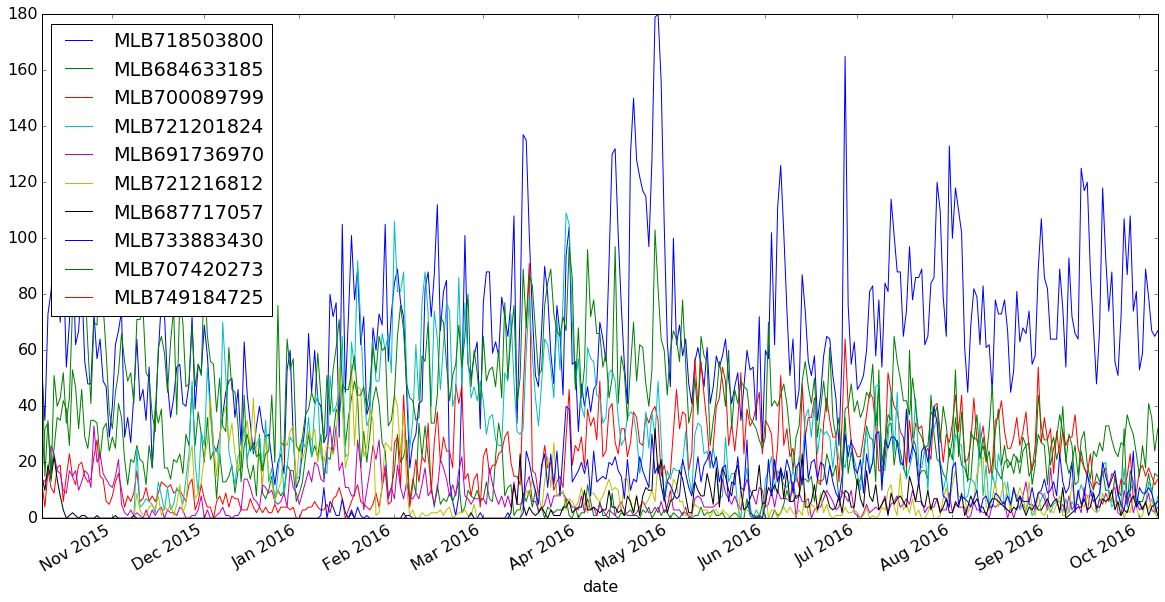

In [48]:
plt.figure()
visits_df.plot(legend=True);

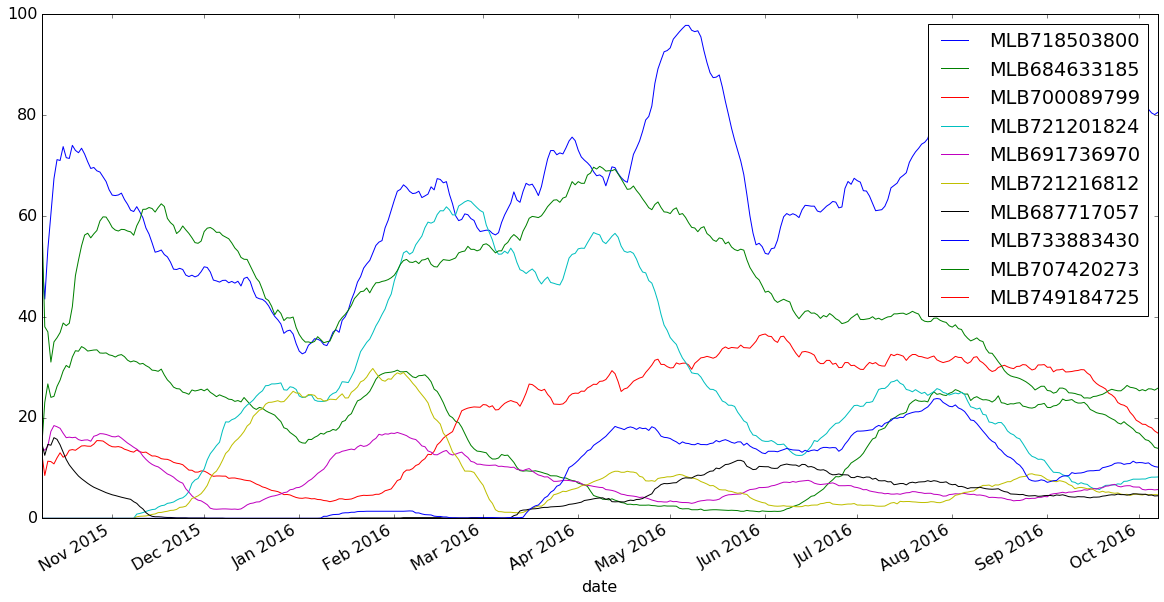

In [49]:
# calculates and plots visits' rolling mean (smoother curves)
#rolling_mean_df = visits_df.resample("1d").sum().fillna(0).rolling(window=30, min_periods=1).mean() #when resampling is needed

plt.figure();
rolling_mean_df = visits_df.rolling(window=30, min_periods=1).mean() # window is the # of days evaluated in rolling mean
rolling_mean_df.plot();

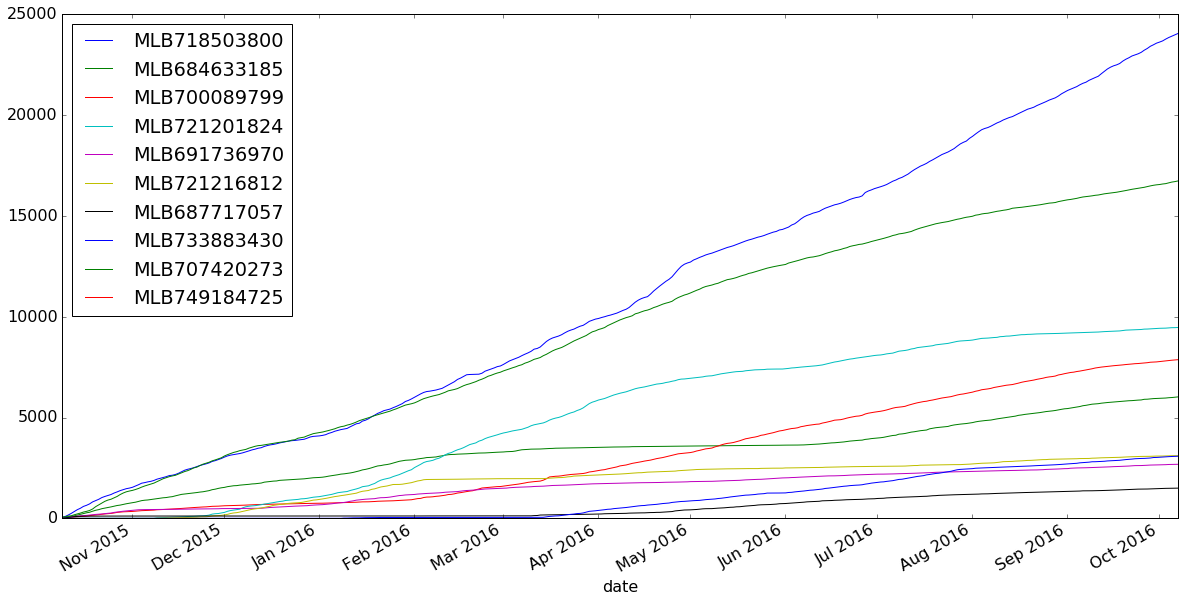

In [50]:
cumulative_visits_df = visits_df.cumsum() # calculates accumulated values to plot
plt.figure();
cumulative_visits_df.plot(legend=True);

## Lista dos itens plotados e URLs

In [52]:
# prints URLs from items in chart

print('URLs dos itens plotados:', '\n')
for item in column_headers:
    print(item + ' - ' + df.loc[item, 'title']) # uses loc taking advantage of indexing by id made previously
    print(df.loc[item, 'permalink'])
    

URLs dos itens plotados: 

MLB718503800 - Cadeira Acrílica Louis Ghost - Design - Nf + Garantia
http://produto.mercadolivre.com.br/MLB-718503800-cadeira-acrilica-louis-ghost-design-nf-garantia-_JM
MLB684633185 - Cadeira Sophia Louis Ghost - Design
http://produto.mercadolivre.com.br/MLB-684633185-cadeira-sophia-louis-ghost-design-_JM
MLB700089799 - Cadeira Acrílica Louis Ghost - Design - Incolor
http://produto.mercadolivre.com.br/MLB-700089799-cadeira-acrilica-louis-ghost-design-incolor-_JM
MLB721201824 - Cadeira Sofia Louis Ghost Com Braço
http://produto.mercadolivre.com.br/MLB-721201824-cadeira-sofia-louis-ghost-com-braco-_JM
MLB691736970 - Cadeira Acrílica Louis Ghost - Design - Preto
http://produto.mercadolivre.com.br/MLB-691736970-cadeira-acrilica-louis-ghost-design-preto-_JM
MLB721216812 - Cadeira Sofia Louis Ghost Sem Braço
http://produto.mercadolivre.com.br/MLB-721216812-cadeira-sofia-louis-ghost-sem-braco-_JM
MLB687717057 - Cadeira Sophia Louis Ghost Em Pc C/ Braço - Cozinha/ja